In [53]:
MAX_EPOCHS = 500
BATCH_SIZE = 128
LEARNING_RATE = 0.001
SMILES_COL = 'Column3'
WAVELENGTH_COL = 'Column5'
URL = '/home/ishii/graduation_research/data/csvファイル/dft_B3LYP_6-31G*_zinc_for-sale_1000000_0to100000.csv'

In [54]:
#変更後のデータセット
import torch
import pandas as pd
from collections import Counter

class Dataset(torch.utils.data.Dataset):
    def __init__(self, url, smiles_col, wavelength_col):
        self.max_length = 0
        self.dummy_char = '_'
        
        self.url = url
        self.smiles_col = smiles_col
        self.smiles = []
        self.words = self.load_words()
        self.uniq_words = self.get_uniq_words()
        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}
        self.words_indexes = [self.word_to_index[w] for w in self.words]

        self.wavelength_col = wavelength_col
        self.wavelengths = []
        self.items = self.generate_items()
        
        self.dummmy_index = self.word_to_index[self.dummy_char]

    def load_words(self):
        train_df = pd.read_csv(self.url, usecols=[SMILES_COL])
        self.smiles = list(train_df[self.smiles_col])
        for i, smile in enumerate(self.smiles):
            new_smile = smile[1:]
            self.smiles[i] = new_smile
        self.max_length = max(len(smile) for smile in self.smiles)
        self.smiles = list(smile.ljust(self.max_length, self.dummy_char) for smile in self.smiles)
        train_df = pd.Series(self.smiles)
        text = train_df.str.cat(sep=' ')
        text = "".join(text.split(' '))
        return [text[i] for i in range(len(text))]
    
    def generate_items(self):
        train_df = pd.read_csv(self.url, usecols=[WAVELENGTH_COL])
        self.wavelengths = list(train_df[self.wavelength_col])
        items = []
        for i, smile in enumerate(self.smiles):
            smile = list(smile)
            items.append([self.word_to_index[w] for w in smile])
        return items

    def get_uniq_words(self):
        word_counts = Counter(self.words)
        return sorted(word_counts, key=word_counts.get, reverse=True)

    def __len__(self):
        return len(self.wavelengths)

    def __getitem__(self, index):
        return (
            torch.tensor(self.items[index]),
            torch.tensor(self.wavelengths[index])
        )

In [55]:
dataset = Dataset(url=URL, smiles_col=SMILES_COL, wavelength_col=WAVELENGTH_COL)

In [56]:
print(dataset[1])

(tensor([ 6,  1,  5,  1,  1,  1,  3,  2, 20,  4,  1,  1,  5,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0]), tensor(248.7000))


In [57]:
print(len(dataset))

87628


In [58]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=2)

In [59]:
for batch, (x, y) in enumerate(dataloader):
    print(x)
    print(y)
    if batch == 10:
        break

tensor([[ 6,  1,  5,  1,  1,  1,  1,  3,  6,  4,  1,  5,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0],
        [ 6,  1,  5,  1,  1,  1,  3,  2, 20,  4,  1,  1,  5,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0]])
tensor([239.7600, 248.7000])
tensor([[ 2,  8,  2,  3,  2, 23,  9,  4,  2,  3,  8,  6,  4,  6,  2,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
   

In [60]:
#変更後のモデル
import torch

class LSTM_Predictor(torch.nn.Module):
    def __init__(self, dataset):
        super(LSTM_Predictor, self).__init__()
        self.lstm_size = 128
        self.embedding_dim = 128
        self.num_layers = 3

        n_vocab = len(dataset.uniq_words)
        self.embedding = torch.nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
            #padding_idxの処理が不明確
            #padding_idx=dataset.dummmy_index
        )
        self.lstm = torch.nn.LSTM(
            input_size=self.lstm_size,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            batch_first=True,
            dropout=0.2,
        )
        self.fc = torch.nn.Linear(self.lstm_size, 1)

    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.fc(output)

        return logits, state

    def init_state(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.lstm_size),
                torch.zeros(self.num_layers, batch_size, self.lstm_size))

In [61]:
#変更後の訓練プロセス
import torch
import numpy as np

def train(dataset, train_dataset, model):
    losses = []
    val_losses = []
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

    for epoch in range(MAX_EPOCHS):
        model.train()
        
        state_h, state_c = model.init_state(BATCH_SIZE)
        state_h = state_h.to(device)
        state_c = state_c.to(device)
        total_loss = 0
        total_val_loss = 0

        for batch, (x, y) in enumerate(train_dataloader):
            if batch < int(len(train_dataloader) * 0.75):
                model.train()
                
                optimizer.zero_grad()
                
                y_pred, (state_h, state_c) = model(x.to(device), (state_h, state_c))
                y_pred_permute = torch.permute(y_pred, (2, 1, 0))
                loss = criterion(y_pred_permute[0][dataset.max_length-1], y.to(device))
                total_loss += loss.item()

                state_h = state_h.detach()
                state_c = state_c.detach()

                loss.backward()
                optimizer.step()
                
            else:
                model.eval()
                
                y_pred, (state_h, state_c) = model(x.to(device), (state_h, state_c))
                y_pred_permute = torch.permute(y_pred, (2, 1, 0))
                val_loss = criterion(y_pred_permute[0, dataset.max_length-1], y.to(device))
                total_val_loss += val_loss.item()    
                
                state_h = state_h.detach()
                state_c = state_c.detach()
        
        average_total_train_loss = total_loss / int(len(train_dataloader) * 0.75)
        average_total_val_loss = total_val_loss / (len(train_dataloader) - int(len(train_dataloader) * 0.75))
        
        print("Epoch: {}, train_Loss: {:.3f}, val_Loss: {:.3f}".format(
            epoch+1, 
            average_total_train_loss,
            average_total_val_loss
        ))
        losses.append(average_total_train_loss)
        val_losses.append(average_total_val_loss)
    return losses, val_losses

In [62]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device: " + str(device) + '\n')


device: cuda:0



In [63]:
dataset = Dataset(url=URL, smiles_col=SMILES_COL, wavelength_col=WAVELENGTH_COL)
n_samples = len(dataset)
indices = list(range(n_samples))
train_size = int(n_samples * 0.8)
test_size = n_samples - train_size

train_dataset = torch.utils.data.Subset(dataset, indices[:train_size])
test_dataset = torch.utils.data.Subset(dataset, indices[train_size:])

In [64]:
print(len(train_dataset))
print(len(test_dataset))


70102
17526


In [65]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True)
print(int(len(train_dataloader) * 0.75))
print(len(train_dataloader) - int(len(train_dataloader) * 0.75))

410
137


In [66]:
model = LSTM_Predictor(dataset)
model = model.to(device)
train_losses, val_losses = train(dataset, train_dataset, model)

Epoch: 1, train_Loss: 83918.353, val_Loss: 67630.874
Epoch: 2, train_Loss: 58088.973, val_Loss: 45932.134
Epoch: 3, train_Loss: 39256.371, val_Loss: 30177.307
Epoch: 4, train_Loss: 25712.751, val_Loss: 19098.839
Epoch: 5, train_Loss: 16361.102, val_Loss: 11704.740
Epoch: 6, train_Loss: 10273.351, val_Loss: 7118.494
Epoch: 7, train_Loss: 6618.096, val_Loss: 4549.555
Epoch: 8, train_Loss: 4651.543, val_Loss: 3302.352
Epoch: 9, train_Loss: 3739.365, val_Loss: 2810.156
Epoch: 10, train_Loss: 3393.314, val_Loss: 2671.277
Epoch: 11, train_Loss: 3294.478, val_Loss: 2655.369
Epoch: 12, train_Loss: 3277.204, val_Loss: 2664.517
Epoch: 13, train_Loss: 3277.619, val_Loss: 2672.206
Epoch: 14, train_Loss: 3279.135, val_Loss: 2676.459
Epoch: 15, train_Loss: 3279.647, val_Loss: 2679.127
Epoch: 16, train_Loss: 3279.513, val_Loss: 2681.138
Epoch: 17, train_Loss: 3279.020, val_Loss: 2682.651
Epoch: 18, train_Loss: 3278.280, val_Loss: 2683.641
Epoch: 19, train_Loss: 3277.380, val_Loss: 2684.144
Epoch: 20,

In [67]:
def predect(dataset, test_dataset, model):
    model.eval()
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=5, drop_last=True)

    index = np.random.choice(len(test_dataloader))
    
    for batch, (x, y) in enumerate(test_dataloader):
    
        smiles, wavelength = x, y
        break
    state_h, state_c = model.init_state(5)
    state_h = state_h.to(device)
    state_c = state_c.to(device)
    y_pred, (state_h, state_c) = model(smiles.to(device), (state_h, state_c))
    y_pred_permute = torch.permute(y_pred, (2, 1, 0))    

    print(y_pred_permute)
    print(wavelength)

In [68]:
predect(dataset, test_dataset, model)

tensor([[[  14.5500,  -81.7151,  -81.7151,  -81.7151,  -81.7151],
         [  18.6561, -135.8523, -107.5618, -135.8523, -135.8523],
         [   2.6926, -122.1999, -141.5083, -122.1999, -133.0245],
         [-128.4654,  -91.1423, -134.7980,  -91.1423, -121.5029],
         [ -34.9340,  -51.2219, -126.2469,  -51.2219,  -47.4559],
         [ -57.8880,  -61.0764, -118.8487,  -61.0764, -103.4670],
         [ -24.2579,  -50.5599, -106.9901,  -50.5599, -149.6742],
         [ -15.0138,  -44.6332, -138.5503,  -44.6332, -122.3770],
         [ -35.8738,  -64.9682, -105.4377,  -35.4145, -128.3328],
         [ -14.4116,  -40.3567,  -89.1473,  -69.2478,  -61.8977],
         [  11.9581,  -28.0963,  -89.9188,  -61.2954,  -55.9325],
         [  57.7219,  -55.2112,  -73.4436,  -40.6783,  -66.5821],
         [ 110.5460,  -50.5090,  -83.9938,  -77.0135,  -66.5376],
         [ 205.5531,  -38.0316,  -72.1703, -139.6108,  -93.9077],
         [ 343.4565,  -68.7247,  -67.5248,  -83.7919, -105.0512],
         [

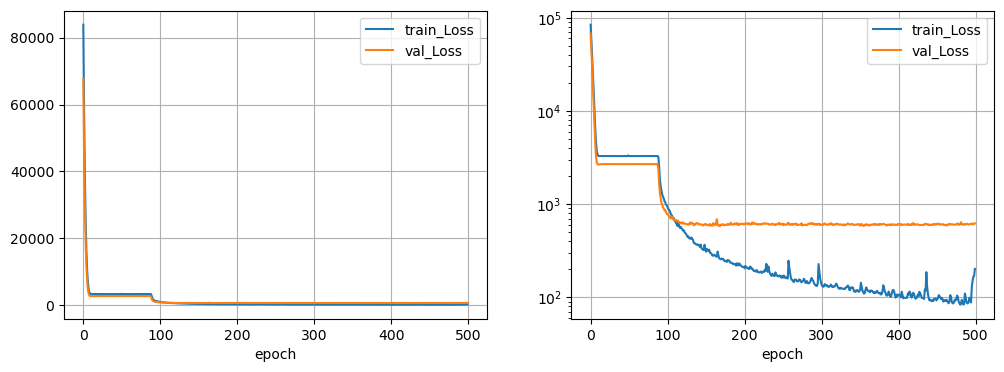

In [69]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
axes[0].plot(train_losses, label="train_Loss")
axes[0].plot(val_losses, label="val_Loss")
axes[0].grid()
axes[0].set_xlabel("epoch")
axes[0].legend()


axes[1].plot(train_losses, label="train_Loss")
axes[1].plot(val_losses, label="val_Loss")
axes[1].grid()
axes[1].set_yscale('log')
axes[1].set_xlabel("epoch")
axes[1].legend()

plt.show()

In [86]:
def test(dataset, test_dataset, model):
    model.eval()
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=True)
    
    criterion = torch.nn.L1Loss()
    
    total_loss = 0
    state_h, state_c = model.init_state(len(test_dataset))
    state_h = state_h.to(device)
    state_c = state_c.to(device)
    
    for batch, (x, y) in enumerate(test_dataloader):
    
        y_pred, (state_h, state_c) = model(x.to(device), (state_h, state_c))
        y_pred_permute = torch.permute(y_pred, (2, 1, 0))    
        loss = criterion(y_pred_permute[0, dataset.max_length-1], y.to(device))
        total_loss += loss.item()

        state_h = state_h.detach()
        state_c = state_c.detach()
    
    return total_loss
        

In [87]:
print("test_Loss: {:.3f}".format(test(dataset, test_dataset, model)))

test_Loss: 25.896


In [88]:
def test(dataset, test_dataset, model):
    model.eval()
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=True)
    
    criterion = torch.nn.MSELoss()
    
    total_loss = 0
    state_h, state_c = model.init_state(len(test_dataset))
    state_h = state_h.to(device)
    state_c = state_c.to(device)
    
    for batch, (x, y) in enumerate(test_dataloader):
    
        y_pred, (state_h, state_c) = model(x.to(device), (state_h, state_c))
        y_pred_permute = torch.permute(y_pred, (2, 1, 0))    
        loss = criterion(y_pred_permute[0, dataset.max_length-1], y.to(device))
        total_loss += loss.item()

        state_h = state_h.detach()
        state_c = state_c.detach()
    
    return total_loss
        

In [89]:
print("test_Loss: {:.3f}".format(test(dataset, test_dataset, model)))

test_Loss: 1602.814


: 